In [1]:
# import importlib.util
# spec = importlib.util.spec_from_file_location("vglib2", "/home/omar/ok/01_dev/_Foreign/_vg/vgnlp/vglib/vglib2.py")
# foo = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(foo)
# vg = foo.Vglib()

In [2]:
import os
import sys
import re

from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import Word2Vec, TfidfModel
from gensim.models.phrases import Phraser, Phrases

import pandas as pd

import spacy
import nltk
from nltk.probability import FreqDist
from itertools import chain
from nltk.text import Text

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import TSNE

In [3]:
# https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/
# https://radimrehurek.com/gensim/models/word2vec.html
# https://stackoverflow.com/questions/46889727/word2vec-what-is-best-add-concatenate-or-average-word-vectors

# a) Summing
# https://inneka.com/programming/python/how-to-calculate-the-sentence-similarity-using-word2vec-model-of-gensim-with-python/

In [4]:
nlp = spacy.load("en_core_web_md")

In [5]:
# word embed => vocab
# part of speech tag all nouns (entity relation NER), tag all verbs
# https://spacy.io/usage/linguistic-features#dependency-parse

# similarity between noun and verbnn

In [6]:
JL = "./jobsdb_notcrawl_sample_001.jl"
df = pd.read_json(JL, lines=True)

In [7]:
req = [
    item["jobDescription"].split("equirement")[0].replace("\n", " ").replace("\r", " ").replace("\xa0", "")
    for item in df["jobDetail"]
]

In [8]:
req

['This is a great opportunity for a candidate with prior legal experience who is looking to excel and develop their career rapidly! Client DetailsOur client offers extensive legal services to their top-tier clients spread across their legal team. They use a combination of technology and online solutions to service their clients as well as act as in-house Counsel for fund formation issues.DescriptionDraft, review and update agreements (such as investment management agreements, prospectuses, fund-related documentation, third party service provider agreements)Give assistance in producing reports for marketing materials and client updatesLiaise with external counsel when required to assist in resolving any legal/regulatory-related issuesDevelop and maintain a sound understanding and knowledge of applicable legal/regulatory r',
 'AIA Group AIA is the largest independent publicly listed pan-Asian life insurance group   – with a presence in 18 markets around the Asia-Pacific region. It is the

In [9]:
texts = [
    "This is a list of docker-compose files you can tell Lando to start. The paths are relative to the root of your project. Generally this option is not used in favor of Lando recipes and/or services but is an option that makes sense under some circumstances.Note that services located in these files will still get injected with Lando's default environment variables and also be networked like any other Lando service but will not get any of the extra Lando secret sauce.If you are interested in using something Lando does not currently offer as a service or recipe we recommend looking at the custom compose service.",
    "    Shop around for a recipe that can serve as a good starting point. lando init is helpful for this.Add in additional services when you need more JUICEDefine more complex tooling and events to simplify difficult command patterns and automate common tasksAdd in some build steps to further automate setting your services up or to mix in additional project dependenciesDefine custom services as a catch all for anything else you needCreate custom recipes or services to lock down your new power toolsRinse and repeat#    Shop around for a recipe that can serve as a good starting point. lando init is helpful for this.Add in additional services when you need more JUICEDefine more complex tooling and events to simplify difficult command patterns and automate common tasksAdd in some build steps to further automate setting your services up or to mix in additional project dependenciesDefine custom services as a catch all for anything else you needCreate custom recipes or services to lock down your new power toolsRinse and repeat#",
    "When I just started using Hooks, I was confused by all of those questions too. Even when writing the initial docs, I didn’t have a firm grasp on some of the subtleties. I’ve since had a few “aha” moments that I want to share with you. This deep dive will make the answers to these questions look obvious to you.",
]

In [10]:
texts = req

In [11]:
# Cleaning data - remove punctuation from every newsgroup text
sentences = []
# Go through each text in turn
for ii in range(len(texts)):
    sentences = [re.sub(pattern=r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]', 
                        repl=' ', 
                        string=x
                       ).strip().split(' ') for x in texts[ii].split('\n') 
                      if not x.endswith('writes:')]
    sentences = [x for x in sentences if x != ['']]
    texts[ii] = sentences

In [12]:
all_sentences = []
for text in texts:
    all_sentences += text

In [13]:
all_sentences

[['This',
  'is',
  'a',
  'great',
  'opportunity',
  'for',
  'a',
  'candidate',
  'with',
  'prior',
  'legal',
  'experience',
  'who',
  'is',
  'looking',
  'to',
  'excel',
  'and',
  'develop',
  'their',
  'career',
  'rapidly',
  '',
  'Client',
  'DetailsOur',
  'client',
  'offers',
  'extensive',
  'legal',
  'services',
  'to',
  'their',
  'top',
  'tier',
  'clients',
  'spread',
  'across',
  'their',
  'legal',
  'team',
  '',
  'They',
  'use',
  'a',
  'combination',
  'of',
  'technology',
  'and',
  'online',
  'solutions',
  'to',
  'service',
  'their',
  'clients',
  'as',
  'well',
  'as',
  'act',
  'as',
  'in',
  'house',
  'Counsel',
  'for',
  'fund',
  'formation',
  'issues',
  'DescriptionDraft',
  '',
  'review',
  'and',
  'update',
  'agreements',
  '',
  'such',
  'as',
  'investment',
  'management',
  'agreements',
  '',
  'prospectuses',
  '',
  'fund',
  'related',
  'documentation',
  '',
  'third',
  'party',
  'service',
  'provider',
  'ag

In [14]:
# Phrase Detection
# Give some common terms that can be ignored in phrase detection
# For example, 'state_of_affairs' will be detected because 'of' is provided here: 
common_terms = ["of", "with", "without", "and", "or", "the", "a"]
# Create the relevant phrases from the list of sentences:
phrases = Phrases(all_sentences, common_terms=common_terms)
# The Phraser object is used from now on to transform sentences
bigram = Phraser(phrases)
# Applying the Phraser to transform our sentences is simply
all_sentences = list(bigram[all_sentences])

In [15]:
"""
This example, with only 564k sentences, is a toy example,
and the resulting word embeddings would not be expected
to be as useful as those trained by Google / Facebook on larger corpus’ of training data.
"""

"""
WordNet
The database contains 155,327 words organized in 175,979 synsets
for a total of 207,016 word-sense pairs;
in compressed form, it is about 12 megabytes in size.
"""

'\nWordNet\nThe database contains 155,327 words organized in 175,979 synsets\nfor a total of 207,016 word-sense pairs;\nin compressed form, it is about 12 megabytes in size.\n'

In [16]:
# model = Word2Vec(all_sentences, 
#                  min_count=3,   # Ignore words that appear less than this
#                  size=200,      # Dimensionality of word embeddings
#                  workers=2,     # Number of processors (parallelisation)
#                  window=5,      # Context window for words during training
#                  iter=30)       # Number of epochs training over corpus
# model.save("word2vec__job_responsibility_2019-11-21.model")

In [17]:
model = Word2Vec.load("word2vec__job_responsibility_2019-11-21.model")


In [18]:
model.vector_size

200

In [19]:
len(model.wv.vocab)

47294

In [20]:
model.wv.vocab

{'This_is': <gensim.models.keyedvectors.Vocab at 0x7fdda6d74f60>,
 'a': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e048>,
 'great_opportunity': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e080>,
 'for': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e0f0>,
 'candidate': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e128>,
 'with': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e198>,
 'prior_legal': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e1d0>,
 'experience': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e208>,
 'who': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e278>,
 'is': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e2e8>,
 'looking': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e358>,
 'to': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e3c8>,
 'excel': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e438>,
 'and': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e4a8>,
 'develop': <gensim.models.keyedvectors.Vocab at 0x7fdda6d7e518>,
 'their': <gensim.models

In [21]:
model.wv.most_similar('python', topn=30)

[('perl', 0.739906370639801),
 ('Scala', 0.7304075360298157),
 ('Python', 0.6775646209716797),
 ('Informatica', 0.6766178607940674),
 ('Talend', 0.6745677590370178),
 ('shell', 0.6563463807106018),
 ('Hortonworks', 0.6423312425613403),
 ('J2EE', 0.6408932209014893),
 ('jQuery', 0.6390188932418823),
 ('Hibernate', 0.6381134986877441),
 ('Kotlin', 0.6172246336936951),
 ('JavaScript_Java', 0.6127177476882935),
 ('Spark', 0.6123728156089783),
 ('Hive', 0.6109833717346191),
 ('VB', 0.6072014570236206),
 ('Kafka', 0.6047351360321045),
 ('SQL', 0.6039758920669556),
 ('Oracle_PLSQL', 0.603531539440155),
 ('PostgreSQL', 0.6034286022186279),
 ('Vuejs', 0.60042405128479),
 ('Ruby', 0.5988884568214417),
 ('ReactJS', 0.5974233746528625),
 ('Cloudera', 0.5970489978790283),
 ('MySQL', 0.5965946316719055),
 ('scripting', 0.5946428775787354),
 ('PowerBI', 0.5946396589279175),
 ('Cordova', 0.5932754278182983),
 ('PLSQL', 0.5921269059181213),
 ('AJAX', 0.5898987054824829),
 ('Django', 0.5880725383758545)

In [22]:
model.wv.most_similar('use')

[('utilise', 0.4228358268737793),
 ('access', 0.41783905029296875),
 ('usage', 0.41354385018348694),
 ('used', 0.4115314483642578),
 ('leveraging', 0.4064713418483734),
 ('using', 0.3904802203178406),
 ('means', 0.3808995485305786),
 ('leverage', 0.3682895302772522),
 ('deeper', 0.3670620620250702),
 ('Use', 0.3639821410179138)]

In [23]:
model.wv.most_similar('programming')

[('SQL', 0.6104525327682495),
 ('coding', 0.598473846912384),
 ('JavaScript', 0.590789794921875),
 ('scripting', 0.5673296451568604),
 ('programming_languages', 0.562724232673645),
 ('Python', 0.5529848337173462),
 ('Javascript', 0.5355828404426575),
 ('Java', 0.531597375869751),
 ('computer_graphics', 0.5302219986915588),
 ('HTML5', 0.5241732001304626)]

In [24]:
model.n_similarity(['python'], ['J2EE'])

/media/veracrypt1/08_python/_ML/201911_gensim_wordembed/nenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  """Entry point for launching an IPython kernel.


0.6408932

In [25]:
model.wv['python']

array([-0.03551778,  0.01319693,  0.21976519, -0.29183346,  0.69024134,
        0.19263801, -0.4084028 ,  0.07656161,  0.03834514, -0.38199937,
        0.13126928,  0.23157848, -0.63894695,  0.2282276 ,  0.09648328,
       -0.1938441 ,  0.31599087,  0.19755001,  0.10831659,  0.07740882,
       -0.56123316, -0.15113804, -0.453382  ,  0.08570436,  0.3249032 ,
       -0.10609299, -0.2796029 ,  0.2566942 , -0.49541745, -0.2574497 ,
        0.1856108 , -0.05383793, -0.31608856,  0.15127458,  0.08855695,
       -0.05421937,  0.26314816,  0.07585376,  0.32610276, -0.14291161,
       -0.18633148,  0.00096044,  0.00912051, -0.03028719, -0.48162523,
        0.05482362, -0.70311636,  0.01327327,  0.1452028 ,  0.26549634,
        0.06520578,  0.01070197,  0.10551198,  0.196465  ,  0.6256694 ,
       -0.25348476, -0.48945594, -0.20347722, -0.34818324,  0.06666352,
       -0.1829009 ,  0.43103337, -0.27827114, -0.7611928 , -0.29571235,
       -0.00306119, -0.23586427,  0.0348754 , -0.3015298 , -0.24

# SpaCy

In [26]:
passage = texts[2][0]
' '.join(passage)

"Our international banking client is looking for a Data Analyst   Data Scientist with experience in Speech Analytics   NLP to provide critical insights and solution over trends of recorded audio and audio based data to the organization  ResponsibilitiesPerform analysis of customer conversations interactions utilizing an advanced speech analytics solution Validate analysis by listening to subset of calls Construct searches  filters and reports designed for automated analysis and topic identification in recorded conversations from call center and other telephonic conversations like telemarketing  investment product sales  advisory  collections etc Identify trends patterns in customer interaction and non  speech data that present opportunities for improvement to operating efficiencies  customer experience  and process improvement Provide basic speech analytics guidance to the business for the development  design  and implementation of data initiativesCreate innovative ideas to use the Spe

In [27]:
test_text = "Autonomous cars shift insurance liability toward manufacturers"
test_text = ' '.join(passage)
doc = nlp(test_text)
print("{}\t{} {} {} {}".format(
    "root.text".rjust(20),
    "root.dep_".rjust(9),
    "root.head.text".rjust(15),
    "Head POS".ljust(10),
    "Text".ljust(30),
))
print("========================================================================")
for chunk in doc.noun_chunks:
    print("{}\t{} {} {} {}".format(
        chunk.root.text.rjust(20),
        chunk.root.dep_.rjust(9),
        chunk.root.head.text.rjust(15),
        chunk.root.head.pos_.ljust(10),
        chunk.text.ljust(30),
    ))

           root.text	root.dep_  root.head.text Head POS   Text                          
              client	    nsubj         looking VERB       Our international banking client
           Scientist	     pobj             for ADP        a Data Analyst   Data Scientist
          experience	     pobj            with ADP        experience                    
                 NLP	     pobj              in ADP        Speech Analytics   NLP        
            insights	     dobj         provide VERB       critical insights             
            solution	     conj        insights NOUN       solution                      
              trends	     pobj            over ADP        trends                        
                data	     pobj              of ADP        recorded audio and audio based data
        organization	     pobj              to ADP        the organization              
            analysis	    appos    organization NOUN       ResponsibilitiesPerform analysis
        int

In [28]:
# Head: Verb + dep: dobj(direct object)
# ref: https://nlp.stanford.edu/software/dependencies_manual.pdf
# relation types
# https://www.aaai.org/ocs/index.php/AAAI/AAAI11/paper/viewFile/3659/3898

print("{}\t{} {} {} {}".format(
    "root.text".rjust(20),
    "root.dep_".rjust(9),
    "root.head.text".rjust(15),
    "Head POS".ljust(10),
    "Text".ljust(30),
))
print("========================================================================")
for chunk in doc.noun_chunks:
    if chunk.root.head.pos_.find("VERB") != -1 \
    and chunk.root.dep_.find("dobj") != -1 \
    or chunk.root.dep_.find("compound") != -1:
        print("{}\t{} {} {} {}".format(
            chunk.root.text.rjust(20),
            chunk.root.dep_.rjust(9),
            chunk.root.head.text.rjust(15),
            chunk.root.head.pos_.ljust(10),
            chunk.text.ljust(30),
        ))

           root.text	root.dep_  root.head.text Head POS   Text                          
            insights	     dobj         provide VERB       critical insights             
            solution	     dobj       utilizing VERB       an advanced speech analytics solution
            searches	     dobj       listening VERB       Construct searches            
            patterns	     dobj        Identify VERB       trends patterns               
            guidance	     dobj         Provide VERB       basic speech analytics guidance
          technology	     dobj             use VERB       the Speech technology         
              skills	     dobj       utilizing VERB       thinking skills               
           analytics	     dobj         perform VERB       text analytics                
          challenges	     dobj         address VERB       current challenges            
             utility	     dobj       improvise VERB       utility                       
          exp

In [29]:
# Head: Verb + dep: dobj(direct object)
print("{}\t{} {} {} {}".format(
    "root.text".rjust(20),
    "root.dep_".rjust(9),
    "root.head.text".rjust(15),
    "Head POS".ljust(10),
    "Text".ljust(30),
))
print("========================================================================")
for chunk in doc.noun_chunks:
    if True or chunk.root.head.pos_.find("VERB") != -1 \
    and chunk.root.dep_.find("dobj") != -1 \
    or chunk.root.dep_.find("compound") != -1:
        print("{}\t{} {} {} {}".format(
            chunk.root.text.rjust(20),
            chunk.root.dep_.rjust(9),
            chunk.root.head.text.rjust(15),
            chunk.root.head.pos_.ljust(10),
            chunk.text.ljust(30),
        ))

           root.text	root.dep_  root.head.text Head POS   Text                          
              client	    nsubj         looking VERB       Our international banking client
           Scientist	     pobj             for ADP        a Data Analyst   Data Scientist
          experience	     pobj            with ADP        experience                    
                 NLP	     pobj              in ADP        Speech Analytics   NLP        
            insights	     dobj         provide VERB       critical insights             
            solution	     conj        insights NOUN       solution                      
              trends	     pobj            over ADP        trends                        
                data	     pobj              of ADP        recorded audio and audio based data
        organization	     pobj              to ADP        the organization              
            analysis	    appos    organization NOUN       ResponsibilitiesPerform analysis
        int

# Term Frequency

In [30]:
# ref: https://www.ranks.nl/stopwords
stoplist = [
    "the", "R", "to", "with",
    "a", "able", "about", "above", "abst", "accordance", "according", "accordingly", "across", "act", "actually", "added", "adj", "affected", "affecting", "affects", "after", "afterwards", "again", "against", "ah", "all", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "apparently", "approximately", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "auth", "available", "away", "awfully", "b", "back", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "between", "beyond", "biol", "both", "brief", "briefly", "but", "by", "c", "ca", "came", "can", "cannot", "can't", "cause", "causes", "certain", "certainly", "co", "com", "come", "comes", "contain", "containing", "contains", "could", "couldnt", "d", "date", "did", "didn't", "different", "do", "does", "doesn't", "doing", "done", "don't", "down", "downwards", "due", "during", "e", "each", "ed", "edu", "effect", "eg", "eight", "eighty", "either", "else", "elsewhere", "end", "ending", "enough", "especially", "et", "et-al", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "except", "f", "far", "few", "ff", "fifth", "first", "five", "fix", "followed", "following", "follows", "for", "former", "formerly", "forth", "found", "four", "from", "further", "furthermore", "g", "gave", "get", "gets", "getting", "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten", "h", "had", "happens", "hardly", "has", "hasn't", "have", "haven't", "having", "he", "hed", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hers", "herself", "hes", "hi", "hid", "him", "himself", "his", "hither", "home", "how", "howbeit", "however", "hundred", "i", "id", "ie", "if", "i'll", "im", "immediate", "immediately", "importance", "important", "in", "inc", "indeed", "index", "information", "instead", "into", "invention", "inward", "is", "isn't", "it", "itd", "it'll", "its", "itself", "i've", "j", "just", "k", "keep 	keeps", "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "lets", "like", "liked", "likely", "line", "little", "'ll", "look", "looking", "looks", "ltd", "m", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "million", "miss", "ml", "more", "moreover", "most", "mostly", "mr", "mrs", "much", "mug", "must", "my", "myself", "n", "na", "name", "namely", "nay", "nd", "near", "nearly", "necessarily", "necessary", "need", "needs", "neither", "never", "nevertheless", "new", "next", "nine", "ninety", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "now", "nowhere", "o", "obtain", "obtained", "obviously", "of", "off", "often", "oh", "ok", "okay", "old", "omitted", "on", "once", "one", "ones", "only", "onto", "or", "ord", "other", "others", "otherwise", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "owing", "own", "p", "page", "pages", "part", "particular", "particularly", "past", "per", "perhaps", "placed", "please", "plus", "poorly", "possible", "possibly", "potentially", "pp", "predominantly", "present", "previously", "primarily", "probably", "promptly", "proud", "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran", "rather", "rd", "re", "readily", "really", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "respectively", "resulted", "resulting", "results", "right", "run", "s", "said", "same", "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven", "several", "shall", "she", "shed", "she'll", "shes", "should", "shouldn't", "show", "showed", "shown", "showns", "shows", "significant", "significantly", "similar", "similarly", "since", "six", "slightly", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specifically", "specified", "specify", "specifying", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure"
]

In [31]:
# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists#45323085
def itertools_chain_from_iterable(lsts):
    return list(chain.from_iterable(lsts))

In [32]:
biglist = itertools_chain_from_iterable(all_sentences)

In [33]:
fdist1 = FreqDist(biglist)

In [34]:
[x for x in fdist1.most_common(500) if x[0] not in stoplist]

[('business', 18107),
 ('team', 17780),
 ('Responsibilities', 15888),
 ('management', 13453),
 ('experience', 11940),
 ('support', 11509),
 ('including', 10275),
 ('will_be', 9960),
 ('work', 9799),
 ('sales', 9220),
 ('Assist', 8601),
 ('development', 8561),
 ('Hong_Kong', 8548),
 ('projects', 8417),
 ('project', 8054),
 ('company', 8049),
 ('services', 7434),
 ('Job', 7385),
 ('To', 6986),
 ('clients', 6375),
 ('The', 6366),
 ('ensure', 6096),
 ('Provide', 6006),
 ('you', 5979),
 ('provide', 5867),
 ('system', 5818),
 ('their', 5664),
 ('customers', 5545),
 ('marketing', 5466),
 ('financial', 5439),
 ('reports', 5342),
 ('customer', 5341),
 ('design', 5341),
 ('skills', 5184),
 ('analysis', 5152),
 ('will', 5086),
 ('service', 5019),
 ('Responsible_for', 4915),
 ('Handle', 4589),
 ('quality', 4589),
 ('data', 4530),
 ('product', 4529),
 ('looking_for', 4514),
 ('products', 4468),
 ('IT', 4447),
 ('activities', 4421),
 ('Our_client', 4248),
 ('performance', 4167),
 ('opportunities', 4

In [35]:
[x for x in biglist if x.find('_') != -1]

['This_is',
 'great_opportunity',
 'Client_DetailsOur',
 'top_tier',
 'spread_across',
 'as_well',
 'act_as',
 'such_as',
 'third_party',
 'service_provider',
 'marketing_materials',
 'external_counsel',
 'when_required',
 'regulatory_r',
 'AIA_Group',
 'largest_independent',
 'publicly_listed',
 'pan_Asian',
 'life_insurance',
 '18_markets',
 'Asia_Pacific',
 'It_is',
 'life_insurer',
 'has_wholly',
 'owned_main',
 'operating_subsidiaries',
 '18_markets',
 'Asia_Pacific',
 'an_extensive',
 'network_of_250',
 '000_agents',
 'over_20',
 '000_employees',
 'It_has',
 'total_assets',
 'US_216',
 'Main_Board',
 'Stock_Exchange',
 'Hong_Kong',
 'code_“1299”',
 'American_Depositary',
 'Level_1',
 'being_traded',
 'over_the_counter',
 'ticker_symbol',
 'at_31',
 'December_2018',
 'third_largest',
 'constituents_of_The',
 'Hang_Seng',
 'Job_Description',
 'consultative_needs',
 'such_as',
 'risk_management',
 'retirement_planning',
 'potential_clients',
 'wide_range',
 'products_●Maintain',
 'r

In [36]:
# find top 100's top 30 similar
similars_list = []
for x in fdist1.most_common(100):
    if x[0] not in stoplist:
        similars = model.wv.most_similar(x[0], topn=30)
        similars_list.extend([y[0] for y in similars])
        
print(similars_list)

['and', 'the', 'to', 'businesses', 'sales', 'business_unit', 'of', 'strategic', 'commercial', 'channel', 'in', 'category', 'for', 'Business', 'with', 'team', 'market', 'markets', 'key', 'partnership', 'BU', 'corporate', 'strategy', 'business_objectives', 'product', 'on', 'regional', 'business_units', 'new', 'management', 'teams', 'Team', 'department', 'team_members', 'to', 'crossfunctional_teams', 'the', 'and', 'function', 'division', 'manager', 'business', 'efforts', 'internal_teams', 'organization', 'office', 'teammates', 'small_team', 'group', 'Sales_Team', 'managers', 'regional', 'a', 'business_unit', 'of', 'colleagues', 'for', 'Head', 'staff', 'engineers', 'Job_Responsibilities', 'Key_Responsibilities', 'Job_Description', 'Job_Duties', 'Key_responsibilities', 'Responsibility', 'RESPONSIBILITIES', 'Job_Descriptions', 'Main_Responsibilities', 'Major_Responsibilities', 'Roles_and_Responsibilities', 'Duties', 'Principal_responsibilities', 'Scope_of_Duties', 'Job_Summary', 'Job_descrip

# Visualize Word2Vec

In [37]:
# ref: https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d


In [38]:
the_keys = [x[0] for x in fdist1.most_common(500) if x[0] not in stoplist][430:435]
embedding_clusters = []
word_clusters = []
for word in the_keys:
    print(word)
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=10):
        print("\t{}".format(similar_word))
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

based_on
	determine
	into
	translate_into
	Analyse
	considering
	against
	according
	utilizing
	compare
	Analyze_and_evaluate
Proficient
	Proficiency
	Strong_computer
	Excel_PowerPoint
	Well_versed
	PowerPoint_and_Excel
	Microsoft_Word
	VLook_Up
	MS
	High_proficiency
	PowerPoint_Excel
construction
	interior
	interior_design
	site_supervision
	engineering
	architectural
	structural
	tendering
	MEP
	contractor
	site_works
understand
	explain
	articulate
	determine
	identify
	address
	influence
	discover
	better_understand
	interpret
	understanding
Degree
	Bachelor_degree
	Degree_holder
	Diploma_or_above
	Bachelor's_degree
	Bachelor’s_degree
	Bachelor’s_Degree
	degree_or_above
	Degree_or_above
	Diploma
	University_graduate


In [39]:
len(embedding_clusters)

5

In [40]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [41]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()




'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

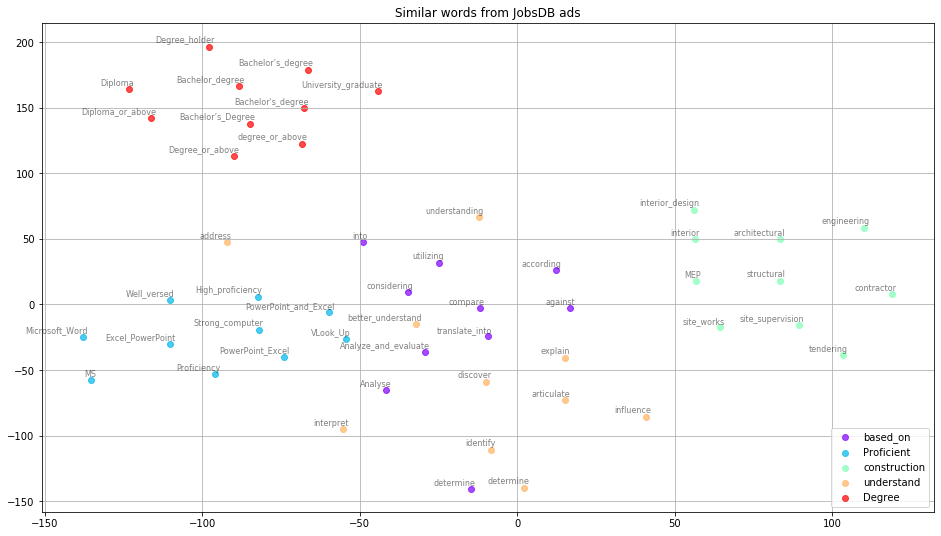

In [42]:
tsne_plot_similar_words(
    'Similar words from JobsDB ads',
    the_keys,
    embeddings_en_2d,
    word_clusters,
    0.7,
    'similar_words.png')

# Part of Speech

In [43]:
tokens = [x[0] for x in fdist1.most_common(500) if x[0] not in stoplist]

In [44]:
nltk.pos_tag(tokens)

[('business', 'NN'),
 ('team', 'NN'),
 ('Responsibilities', 'NNP'),
 ('management', 'NN'),
 ('experience', 'NN'),
 ('support', 'NN'),
 ('including', 'VBG'),
 ('will_be', 'JJ'),
 ('work', 'NN'),
 ('sales', 'NNS'),
 ('Assist', 'NNP'),
 ('development', 'NN'),
 ('Hong_Kong', 'NNP'),
 ('projects', 'NNS'),
 ('project', 'VBP'),
 ('company', 'NN'),
 ('services', 'NNS'),
 ('Job', 'NNP'),
 ('To', 'TO'),
 ('clients', 'NNS'),
 ('The', 'DT'),
 ('ensure', 'VB'),
 ('Provide', 'NNP'),
 ('you', 'PRP'),
 ('provide', 'VBP'),
 ('system', 'NN'),
 ('their', 'PRP$'),
 ('customers', 'NNS'),
 ('marketing', 'VBG'),
 ('financial', 'JJ'),
 ('reports', 'NNS'),
 ('customer', 'NN'),
 ('design', 'NN'),
 ('skills', 'VBZ'),
 ('analysis', 'NN'),
 ('will', 'MD'),
 ('service', 'VB'),
 ('Responsible_for', 'NNP'),
 ('Handle', 'NNP'),
 ('quality', 'NN'),
 ('data', 'NNS'),
 ('product', 'NN'),
 ('looking_for', 'NN'),
 ('products', 'NNS'),
 ('IT', 'NNP'),
 ('activities', 'NNS'),
 ('Our_client', 'NNP'),
 ('performance', 'NN'),
 

In [45]:
# edges/nodes
[x for x in nltk.pos_tag(tokens)]
# if x[1] == 'NN'
# if x[1].find('NN') != -1

[('business', 'NN'),
 ('team', 'NN'),
 ('Responsibilities', 'NNP'),
 ('management', 'NN'),
 ('experience', 'NN'),
 ('support', 'NN'),
 ('including', 'VBG'),
 ('will_be', 'JJ'),
 ('work', 'NN'),
 ('sales', 'NNS'),
 ('Assist', 'NNP'),
 ('development', 'NN'),
 ('Hong_Kong', 'NNP'),
 ('projects', 'NNS'),
 ('project', 'VBP'),
 ('company', 'NN'),
 ('services', 'NNS'),
 ('Job', 'NNP'),
 ('To', 'TO'),
 ('clients', 'NNS'),
 ('The', 'DT'),
 ('ensure', 'VB'),
 ('Provide', 'NNP'),
 ('you', 'PRP'),
 ('provide', 'VBP'),
 ('system', 'NN'),
 ('their', 'PRP$'),
 ('customers', 'NNS'),
 ('marketing', 'VBG'),
 ('financial', 'JJ'),
 ('reports', 'NNS'),
 ('customer', 'NN'),
 ('design', 'NN'),
 ('skills', 'VBZ'),
 ('analysis', 'NN'),
 ('will', 'MD'),
 ('service', 'VB'),
 ('Responsible_for', 'NNP'),
 ('Handle', 'NNP'),
 ('quality', 'NN'),
 ('data', 'NNS'),
 ('product', 'NN'),
 ('looking_for', 'NN'),
 ('products', 'NNS'),
 ('IT', 'NNP'),
 ('activities', 'NNS'),
 ('Our_client', 'NNP'),
 ('performance', 'NN'),
 

In [46]:
# relation
[x for x in nltk.pos_tag(tokens) if x[1].find('V') != -1]

[('including', 'VBG'),
 ('project', 'VBP'),
 ('ensure', 'VB'),
 ('provide', 'VBP'),
 ('marketing', 'VBG'),
 ('skills', 'VBZ'),
 ('service', 'VB'),
 ('develop', 'VBP'),
 ('such_as', 'VBZ'),
 ('working', 'VBG'),
 ('compliance', 'VBP'),
 ('required', 'VBN'),
 ('maintain', 'VBP'),
 ('accounting', 'VBG'),
 ('as_assigned', 'VBN'),
 ('achieve', 'VBP'),
 ('leading', 'VBG'),
 ('Ensure', 'VBP'),
 ('prepare', 'VBP'),
 ('assigned', 'VBN'),
 ('providing', 'VBG'),
 ('handling', 'VBG'),
 ('works', 'VBZ'),
 ('managing', 'VBG'),
 ('join', 'VBP'),
 ('processes', 'VBZ'),
 ('e_g', 'VBD'),
 ('be_used', 'VBD'),
 ('testing', 'VBG'),
 ('developing', 'VBG'),
 ('existing', 'VBG'),
 ('relationships', 'VBZ'),
 ('–', 'VBP'),
 ('based', 'VBN'),
 ('as_required', 'VBD'),
 ('English_and_Chinese', 'VBP'),
 ('coordinate', 'VB'),
 ('help', 'VBP'),
 ('in_accordance', 'VB'),
 ('by_clicking', 'VBG'),
 ('now_looking', 'VBG'),
 ('preparing', 'VBG'),
 ('Accounting', 'VBG'),
 ('supporting', 'VBG'),
 ('improve', 'VB'),
 ('not_li

# Concordance

In [47]:
# 平衡語料庫 parallel corpus
# http://lingcorpus.iis.sinica.edu.tw/modern/

In [48]:
textList = Text(biglist)

In [49]:
textList.concordance('brand')

Displaying 25 of 2215 matches:
jects as_assigned Job R A luxury W J brand is hiring a seasoned Wholesale Direc
ill_be responsible_for re strategize brand marketing for Asia_Pacific Leading t
ttitude Swire_Hotels – our corporate brand which champions quality with a refre
e what our brands stand for creating brand level marketing_materials for use ac
te marketing efforts and cascade new brand material to them The new team member
ill_be to support the development of brand materials for our three brands The H
brands The House Collective EAST and brand Swire_Hotels Purpose of Job Support 
he central Marketing team to develop brand materials for The House Collective E
EAST and Swire_Hotels brands such_as Brand films and other content Photography 
ms and other content Photography and brand imagery Brand guidelines Collateral 
ontent Photography and brand imagery Brand guidelines Collateral materials e_g 
 materials Hotel amenities and gifts Brand presentation_materials for Sales_Tea
 teams an

In [50]:
textList.concordance('insurance')

Displaying 25 of 1949 matches:
 of a wide_range of investment and insurance products_●Maintain good customer r
ent_publicly listed_PAN ASIAN_life insurance group in the world It_has wholly_o
s_than1 of the world’s_leadinglife insurance and financial services professiona
g_experience and to understand the Insurance Industry in acomprehensive way A b
verseas Job R Our_client a leading insurance group is looking_for a strong IT P
ing their new next_generation life Insurance POS platform The_selected candidat
ces including_deposits investments insurance mortgages credit_cards and persona
relationship_managers in exploring insurance needs oftheir existing client port
_up paper works including shipping insurance arrangements contracts corresponde
ual leave Job DescriptionA leading insurance company is looking_for customer_se
ew process of various benefits and insurance policies Keep_abreast of local leg
linical hospitalization_and_dental insurance To discuss_this opportunity furthe
 problems

In [51]:
textList.concordance('credit_cards')

Displaying 25 of 45 matches:
 investments insurance mortgages credit_cards and personal_loans to help our c
ge of banking_products including credit_cards loans and bank accounts to prosp
ations and handling enquiries on credit_cards and consumer_banking products En
 investments insurance mortgages credit_cards and personal_loans to help our c
ng and advertising_campaigns for credit_cards including Brand Branch and PR Ca
 generic credit cards co branded credit_cards affinity cards and commercial ca
acquisition on unsecured_loan or credit_cards product Formulate distribution a
l sales transactions Handle cash credit_cards properly Process credit_card tra
 investments insurance mortgages credit_cards and personal_loans to help our c
 duties of bank products such_as credit_cards and loans by making use of digit
uest experience Proceed cash and credit_cards payment Assist floor team when_n
iver checks and proceed cash and credit_cards payments Carry dirty plates glas
nking products such_as 

In [52]:
textList.concordance('sales_and_profit')

Displaying 25 of 45 matches:
_follow up and achieve company sales_and_profit targets Coordinate_with_intern
ent portfolio and grow company sales_and_profit Be in charge of the full sales
their loyalty to Lane_Crawford Sales_and_Profit To achieve agreed monthly sale
their loyalty to Lane_Crawford Sales_and_Profit To achieve agreed monthly sale
op the team_members to achieve sales_and_profit target Ensure long_term busine
iness opportunities to achieve sales_and_profit targets Establish_and_maintain
or ResponsibilitiesMeeting the sales_and_profit goal of the company by driving
e that is focused_on achieving sales_and_profit goals Determine and communicat
he Account_Director to achieve sales_and_profit targets Develop_and_maintain g
alogue to achieve departmental sales_and_profit targets Responsible_for placin
and_monitor the development of sales_and_profit versus the annual business pla
their loyalty to Lane_Crawford Sales_and_Profit To achieve agreed monthly sale
s to facilitate achieve

In [53]:
textList.concordance('data_science')

Displaying 25 of 88 matches:
approach with the tool Work with data_science analytics teams to perform text_
arties to complete analytics and data_science use_cases Evaluate_and_recommend
ver 3_years Our team skills span data_science architecture back_end front_end 
ience in data_analytics modeling data_science quantitative analytics projects 
tal touchpoints Collaborate with data_science team to ensure models are develo
advanced modelscripts to support data_science analytics initiatives on Artific
' experience in a data_analytics data_science role Experience in R Python Java
levelsPartner with analytics and data_science to analyze data from various rep
or talented students with strong data_science background and business_acumen w
iences including market_research data_science digital analytics finance and co
que and limited projects utilize data_science Artificial_Intelligence Machine_
advanced modelscripts to support data_science analytics initiatives on Artific
tion as to support anal

In [54]:
textList.concordance('data_scientist')

Displaying 25 of 28 matches:
t_is looking_for a Data_Analyst Data_Scientist with experience in Speech Analy
will_be considered_as Associate Data_Scientist Key_Responsibilities Work with 
hey_are currently_looking for a Data_Scientist to drive data analysis and mach
 Your key_responsibilities As a Data_Scientist you will work within the FS Tec
will_be considered_as Associate Data_Scientist Fresh_graduates are_welcome to 
ence will consider as Associate Data_Scientist Responsibilities Technology dri
th They_are currently_seeking a Data_Scientist to help_transform their data in
rofessional to join_our team as Data_Scientist In_this role you will ​Identify
eeds they_are inviting a Senior Data_Scientist to join_their Machine_Learning 
s and metrics Work_closely with data_scientist project team and development te
e business they_are looking_for Data_Scientist to join_their team What_you wil
 and metrics• Work_closely with data_scientist project team and development te
China is looking to hir

In [55]:
textList.concordance('data_visualization')

Displaying 25 of 50 matches:
uage is a plusExperience with data_visualization e_g Qlikview is desired Fluen
data pipeline Experience with data_visualization tools like Power_BI Self_moti
ard and Best practices Master data_visualization tools such_as Tableau Deliver
ues and solutionsExpertise in data_visualization tools_and_techniques experien
ter and maintain database and data_visualization solutions Assist Group Senior
gs_and_discover insights with data_visualization tools Build real_time integra
data_warehouse data marts and data_visualization data governance as_well as ne
n Work with business_units on data_visualization KPI metric reporting business
time data integration ETL ELT data_visualization and data_analytics Deep_under
ork is_a_must Experience with data_visualization techniques and tools e_g Tabl
e an_advantage Proficiency in data_visualization tools ideally Tableau Essenti
to perform data_analytics and data_visualization i_e Tableau is strongly_prefe
database Develop dashbo

In [56]:
def text_to_vec(in_text):
    return [
        [word
            for word in document.lower().split()
            if word not in stoplist]
        for document in in_text.split('|')
    ]

In [57]:
def text_to_bow(in_text):
    global stoplist, dictionary

    return [[word
            for word in dictionary.doc2bow(
                    simple_preprocess(text, deacc=True)
                )
            if word not in stoplist]
            for text in in_text.split('|')]

In [58]:
def id2word(lists, id2token):
    newlist = []
    for list1 in lists:
        newlist1 = {}
        for vec in list1:
            newlist1[id2token[vec[0]]] = vec[1]

        sorted_by_value = sorted(
            newlist1.items(),
            key=lambda kv: kv[1],
            reverse=True
        )
        newlist.append(sorted_by_value)
    return newlist

In [59]:
# build dictionary
texts = text_to_vec('|'.join([' '.join(x) for x in all_sentences]))

In [60]:
# build dictionary
dictionary = corpora.Dictionary(texts)

In [61]:
# build tfidf model using dictionary word-id
bow = text_to_bow('|'.join([' '.join(x) for x in all_sentences]))

In [62]:
bow

[[(0, 1),
  (1, 3),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 2),
  (10, 2),
  (11, 1),
  (12, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (20, 1),
  (21, 2),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 5),
  (29, 1),
  (30, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 4),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1)],
 [(14, 1),
  (24, 2),
  (29, 1),
  (30, 1),
  (46, 1),
  (49, 1),
  (68, 2),
  (69, 1),
  (71, 1),
  (72, 1),
  (73, 2),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (82, 1),
  (83, 2),
  (86, 1),
  (90, 1),
  (91, 1),
  (92, 1),
  (93, 1),
  (94, 1),
  (95, 1),
  (96, 1),
  (97, 1),
  (99, 1),
  (100, 1),
  (101, 1),
  (102, 1),
  (103, 1),
  (104, 1),
  (105, 1),
 

In [63]:
# build tfidf model using dictionary word-id
tfidf = TfidfModel(bow)

In [64]:
id2token = {}
for key in dictionary.token2id:
    id2token[dictionary.token2id[key]] = key

In [65]:
len(id2token.keys())

96830

In [66]:
id2token

{0: 'act_as',
 1: 'agreements',
 2: 'applicable',
 3: 'as_well',
 4: 'assist',
 5: 'assistance',
 6: 'candidate',
 7: 'career',
 8: 'client',
 9: 'client_detailsour',
 10: 'clients',
 11: 'combination',
 12: 'counsel',
 13: 'descriptiondraft',
 14: 'develop',
 15: 'documentation',
 16: 'excel',
 17: 'experience',
 18: 'extensive',
 19: 'external_counsel',
 20: 'formation',
 21: 'fund',
 22: 'great_opportunity',
 23: 'house',
 24: 'investment',
 25: 'issues',
 26: 'issuesdevelop',
 27: 'knowledge',
 28: 'legal',
 29: 'maintain',
 30: 'management',
 31: 'marketing_materials',
 32: 'offers',
 33: 'online',
 34: 'prior',
 35: 'producing',
 36: 'prospectuses',
 37: 'rapidly',
 38: 'regulatory',
 39: 'regulatory_r',
 40: 'reports',
 41: 'resolving',
 42: 'review',
 43: 'service',
 44: 'service_provider',
 45: 'services',
 46: 'solutions',
 47: 'sound',
 48: 'spread_across',
 49: 'such_as',
 50: 'team',
 51: 'technology',
 52: 'their',
 53: 'they',
 54: 'third_party',
 55: 'this_is',
 56: 'to

In [67]:
# use td-of

In [68]:
text_idx = 2350
to_test_ads = ' '.join(req[text_idx][0])
print(to_test_ads)

Responsibilities    To assist the project team and act as the representative of the property management company to perform site supervisory duties  defects checking  and inspecting the works     To ensure the works running properly and communicated with all parties concerned     To ensure the sub contractor in conformity with contract  specification  workmanship standards and relevant legislation     To liaise with the project supervisor  developer and contractors to execute the works specifications  working procedures  work schedules  and quality control are strictly followed     Conduct a various statutory inspections     Prepare evaluation and progress report     Monitor all environmental  health and safety aspects of the sub contractors work    R


In [69]:
test_corpus = [dictionary.doc2bow(
            simple_preprocess(text, deacc=True))
            for text in to_test_ads.split('|')]

In [70]:
corpus_tfidf = tfidf[test_corpus]

In [71]:
id2word([x for x in corpus_tfidf], id2token)

[[('works', 0.2827593267648597),
  ('contractors', 0.23266408938511984),
  ('conformity', 0.22520920315618623),
  ('inspecting', 0.22520920315618623),
  ('concerned', 0.20735262385650247),
  ('legislation', 0.1928444140500871),
  ('communicated', 0.18925357651642002),
  ('workmanship', 0.18648970407649193),
  ('defects', 0.18277658217476564),
  ('inspections', 0.1681180126513221),
  ('strictly', 0.1614032021682085),
  ('supervisory', 0.16029833390659803),
  ('representative', 0.1590596054558594),
  ('environmental', 0.15705021083122694),
  ('properly', 0.1538332323835646),
  ('specification', 0.15119743164339056),
  ('contractor', 0.14939584064656838),
  ('running', 0.14781617934661223),
  ('aspects', 0.14723048012246195),
  ('statutory', 0.14576001709643213),
  ('specifications', 0.1407031677064129),
  ('developer', 0.13695582728192443),
  ('health', 0.13567476890336672),
  ('checking', 0.1276338504498172),
  ('evaluation', 0.12265291238718258),
  ('safety', 0.12215358347385698),
  ('